# Load the data

In [1]:
# Import necessary packages
using DrWatson
using JLD2

# Activate the project environment
@quickactivate :FlowComplexity

# Define the file path
file_path = joinpath("./data", "data.jld2")

# Load the data from the specified file
@load file_path sim_array

1-element Vector{Symbol}:
 :sim_array

# Show time series for all chemostats of simulation no. X

In [ ]:
using DataFrames

sim_no = 90
sim = sim_array[sim_no]
nchem = 9

# Define the array that will hold our population time series
max_t = Int(sim.total_time)
nspecies = 10
pop_array = zeros(Int, nchem, max_t, nspecies)

# Populate the population array
time_series_df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)
for i in 1:nchem
    for j in 1:max_t
        for k in 1:nspecies
            filtered_time_series_df = filter(row -> row[:reactor] == i && row[:time] == j && row[:variable] == string(k), time_series_df)
            if nrow(filtered_time_series_df) > 0
                pop_array[i, j, k] = filtered_time_series_df[1, :value]
            end
        end
    end
end

using Plots, FileIO

# Create a 3x3 grid plot
plot_grid = plot(layout = (3, 3))

# Loop over each subplot
for i in 1:nchem
    # Extract the time series data for the i-th plot
    time_series_data = pop_array[i, :, :]
    
    # Create a subplot for each species in the time series
    p = plot()
    for j in 1:nspecies
        plot!(plot_grid[i], 1:max_t, time_series_data[:, j], label = "Species $j", legend = :none)
    end
end


display(plot_grid)

In [2]:
sim_array[90].sim_number
sim_array[90].time_evolution[1][:complete_timeseries]

Dict{Any, Any} with 501 entries:
  56.0  => [10, 23, 223, 738, 1, 1, 2, 1, 3, 1  …  11, 1, 29, 4, 12, 1, 3, 1, 1…
  35.0  => [15, 1, 110, 1, 30, 3, 1, 1, 481, 1  …  1, 1, 1, 47, 1, 152, 1, 2, 1…
  425.0 => [6, 173, 1, 1, 2, 1, 1, 70, 1, 4  …  1, 379, 1, 1, 1, 50, 1, 1, 598,…
  429.0 => [1, 149, 1, 337, 301, 7, 84, 564, 1, 1  …  75, 9, 589, 1, 130, 30, 1…
  60.0  => [1, 1, 1, 1, 1, 1, 1, 234, 4, 49  …  1, 1, 5, 7, 572, 6, 1, 3, 7, 1]
  220.0 => [7, 1, 19, 1, 752, 2, 1, 1, 1, 480  …  1, 3, 4, 411, 4, 5, 59, 1, 39…
  308.0 => [1, 1, 1, 238, 11, 5, 38, 1, 117, 1  …  10, 1, 12, 1, 38, 12, 14, 1,…
  67.0  => [1, 13, 15, 12, 86, 1, 1, 1, 1, 1  …  1, 1, 1, 8, 2, 297, 2, 1, 1, 1]
  215.0 => [1, 362, 4, 9, 66, 2, 39, 126, 1, 18  …  2, 1, 1023, 1, 3, 1, 1, 1, …
  73.0  => [80, 2, 1, 48, 5, 5, 126, 205, 2, 95  …  2, 16, 2, 1, 4, 448, 1, 3, …
  319.0 => [1, 1, 3, 30, 1, 1, 14, 201, 185, 2  …  15, 1, 2, 69, 1, 44, 48, 2, …
  251.0 => [2, 160, 1, 317, 1, 1, 67, 121, 709, 2  …  35, 91, 4, 1, 3, 19, 1,

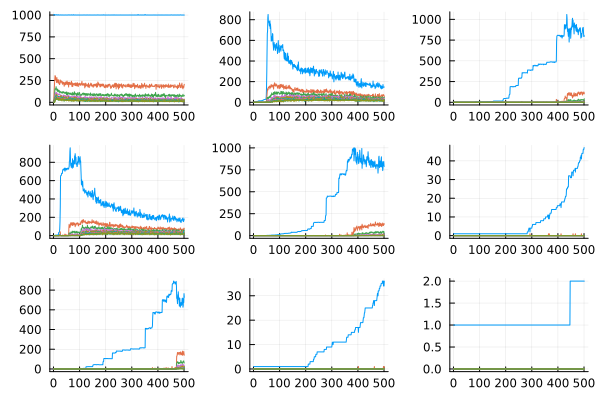

In [257]:
using DataFrames, Plots, FileIO

sim_no = 50
sim = sim_array[sim_no]
nchem = 9

# Define the array that will hold our population time series
max_t = Int(sim.total_time) + 1 # our sim goes to 0...100 so index has to go 1...101
nspecies = 10
pop_array = zeros(Int, nchem, max_t, nspecies)

# Convert the time series to a DataFrame
time_series_df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)

# Populate the population array using efficient DataFrame operations
for row in eachrow(time_series_df)
    
    i = Int(row[:reactor])
    j = round(Int, row[:time]) + 1 # indexing starts at 1
    k = parse(Int, row[:variable]) # to account for absent data (i.e., zero)
    if k > nspecies
        continue
    end
    # println(row)
    # println("i=$i j=$j k=$k")
    pop_array[i, j, k] = row[:value]
end

# Create a 3x3 grid plot
plot_grid = plot(layout = (3, 3))

# Loop over each subplot
for i in 1:nchem
    # Extract the time series data for the i-th plot
    time_series_data = pop_array[i, :, :]
    
    # Create a subplot for each species in the time series
    p = plot()
    for j in 1:nspecies
        plot!(plot_grid[i], 1:max_t, time_series_data[:, j], label = "Species $j", legend = :none)
    end
end

display(plot_grid)

# Plot the Std(M) vs $k_d$ 

## (i.e., the std of monomers vs the outflow)

In [4]:
using DataFrames, Plots, FileIO, Statistics

first_sim = sim_array[1]
nsims = 100
nchem = 9
nspecies = 10
t = 500

# Define the array that will hold our data
pops = zeros(Float64, nsims, nchem, nspecies)

# Loop over all the simulations
for i in 1:100
    try
        sim = sim_array[i]
        df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)
        df = filter(row -> row[:time] == t, df)

        for j in 1:nchem
            df_reactor = filter(row -> row[:reactor] == j, df)

            for k in 1:nspecies
                df_reactor_species = filter(row -> row[:variable] == string(k), df_reactor)
                if nrow(df_reactor_species) > 0
                    pops[i, j, k] = df_reactor_species[1, :value]      
                end
            end
        end
    catch
        continue
    end
end

In [3]:
using DataFrames, Plots, FileIO, Statistics, FlowComplexity
using Base.Threads: @threads

first_sim = sim_array[1]
nsims = 100
nchem = 9
nspecies = 10
t = 500

# Define the array that will hold our data
pops = zeros(Float64, nsims, nchem, nspecies)

# Loop over all the simulations
@threads for i in 1:nsims
    try
        sim = sim_array[i]
        df = FlowComplexity.convert_timeseries_to_tidy_df(sim.time_evolution)
        df = filter(row -> row[:time] == t, df)

        for j in 1:nchem
            df_reactor = df[df.reactor .== j, :]

            for k in 1:nspecies
                df_reactor_species = df_reactor[df_reactor.variable .== string(k), :]
                if nrow(df_reactor_species) > 0
                    pops[i, j, k] = df_reactor_species[1, :value]      
                end
            end
        end
    catch
        continue
    end
end

In [ ]:
display(pops[2,:,:])

In [5]:
stds = zeros(Float64, nsims, nspecies)

for i in 1:100
    for j in 1:nspecies
        stds[i, j] = std(pops[i, :, j])
        # stds = dropdims(stds, dims=2)
    end
end

display(stds)

100×10 Matrix{Float64}:
 333.333  55.0     25.0     14.0      …   6.0      4.0      4.66667  4.33333
 332.169  62.0     26.3333  15.0          6.0      3.66667  5.33333  3.0
 384.776  57.3333  25.3333  17.6667       7.66667  7.33333  3.33333  2.66667
 374.497  69.9138  28.4376  13.4081       6.63325  4.30116  3.97213  1.98606
 333.333  57.0     27.0     13.6667       3.0      3.0      4.33333  4.66667
 330.786  58.0     26.3333  14.0      …   8.0      3.66667  4.33333  3.66667
 333.05   63.0     25.3333   9.33333      4.66667  5.66667  3.66667  4.66667
 333.251  54.0     24.0     10.0          5.0      3.66667  3.0      2.33333
 378.397  65.92    27.6667  15.0          6.0      8.0      4.33333  3.66667
 366.308  84.6066  34.8752  18.3833       6.07134  4.94975  4.0      3.35824
   ⋮                                  ⋱                              
 293.147  51.4533  21.5      9.20296      9.11043  4.15665  6.76387  4.30439
 296.036  56.7893  20.0402  16.1478       5.98841  7.6176   2.6

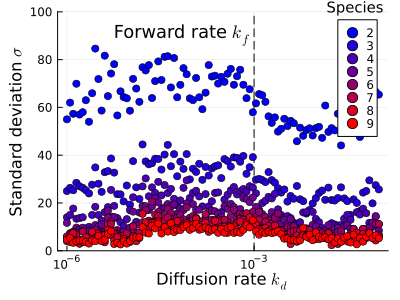

"/Users/alexandre/Documents/academic/3-research/projects/2023 spatial-topology/flow-complexity/milestones/02_std(m)-vs-kd/H_lattice-2way-diffusion/plots/sd-vs-kd.pdf"

In [99]:
using LaTeXStrings

# p = plot()
title = "SD of monomers across diffusion rates \n (lattice, 2-way diffusion, t=500)"
s = scatter(size=(400,300), legend=:topright, ylim=(0,100))

n = 100
vals = exp10.(LinRange(-6,-1,n))

# kf = 0.001
vline!([0.001], label=:none, linestyle=:dash, color=:black)
annotate!(6e-6, 90, text("Forward rate " * L"k_f", :left, 12, color=:black))

annotate!(1.5e-2, 102, text("Species", :left, 10, color=:black))

linear_blue_to_red = cgrad([:blue, :red], scale=:linear)

for i in 2:9
    # plot!(p, vals, stds[:, i], xscale=:log10, xlabel="kd", ylabel="STD(M)", legend= :none)
    scatter!(s, vals, stds[:, i], xscale=:log10, xlabel = "Diffusion rate " * L"k_d", ylabel="Standard deviation " * L"\sigma", label=i,
    marker_z=i, color=linear_blue_to_red, colorbar=false,)
end

# display(p)
display(s)

mkpath("./plots")
savefig("./plots/sd-vs-kd.pdf")

In [ ]:
display(stds)

In [ ]:
std([1000,10,20,50,1,0,0,0,0])

In [136]:
mu = zeros(Float64, nsims, nspecies)

for i in 1:100
    for j in 1:nspecies
        mu[i, j] = mean(pops[i, :, j])
        # stds = dropdims(stds, dims=2)
    end
end

display(mu)

100×10 Matrix{Float64}:
 111.111  18.3333   8.33333   4.66667  …   1.33333   1.55556   1.44444
 114.667  20.6667   8.77778   5.0          1.22222   1.77778   1.0
 190.556  19.1111   8.44444   5.88889      2.44444   1.11111   0.888889
 212.111  35.2222  14.2222    6.55556      1.66667   1.44444   0.777778
 111.111  19.0      9.0       4.55556      1.0       1.44444   1.55556
 122.778  19.3333   8.77778   4.66667  …   1.22222   1.44444   1.22222
 111.889  21.0      8.44444   3.11111      1.88889   1.22222   1.55556
 111.333  18.0      8.0       3.33333      1.22222   1.0       0.777778
 186.444  22.2222   9.22222   5.0          2.66667   1.44444   1.22222
 178.444  42.5556  17.4444    9.22222      2.33333   1.66667   1.44444
   ⋮                                   ⋱                      
 219.444  62.7778  40.3333   28.2222      15.4444   14.3333   14.4444
 211.0    61.4444  38.8889   31.0         15.4444   13.4444   12.2222
 212.0    56.7778  36.8889   29.2222      14.5556   17.6667   14

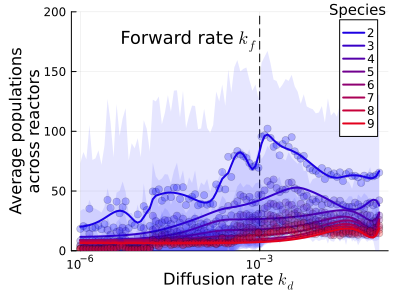

"/Users/alexandre/Documents/academic/3-research/projects/2023 spatial-topology/flow-complexity/milestones/02_std(m)-vs-kd/H_lattice-2way-diffusion/plots/mu-vs-kd.pdf"

In [259]:
using LaTeXStrings, Dierckx, Polynomials, Interpolations

gr()

# p = plot()
title = "Mean of monomers across diffusion rates \n (lattice, 2-way diffusion, t=500)"
s = scatter(size=(400,300), legend=:topright, ylim=(0,200))

n = 100
vals = exp10.(LinRange(-6,-1,n))

# kf = 0.001
vline!([0.001], label=:none, linestyle=:dash, color=:black)
annotate!(5e-6, 175, text("Forward rate " * L"k_f", :left, 12, color=:black))

annotate!(1.5e-2, 202, text("Species", :left, 10, color=:black))

linear_blue_to_red = cgrad([:blue, :red], scale=:linear)

for i in 2:9
    # plot!(p, vals, stds[:, i], xscale=:log10, xlabel="kd", ylabel="STD(M)", legend= :none)
    scatter!(s, vals, mu[:, i], xscale=:log10, xlabel = "Diffusion rate " * L"k_d", ylabel="Average populations\nacross reactors", label=:none,
    marker_z=i, color=linear_blue_to_red, colorbar=false, alpha=0.25)

    upper_bound = mu[:, i] .+ stds[:,i]
    lower_bound = mu[:, i] .- stds[:,i]
    # linealpha à cause de l’esti de bug y save pas le pdf avec lw=0
    plot!(s, vals, upper_bound, fillrange=lower_bound, linealpha=0, fillalpha=0.1, color=linear_blue_to_red, label=:none, linewidth=0)

    x = vals
    y = mu[:, i]

    # function moving_average(data, window_size)
    #     return [mean(data[i:i+window_size-1]) for i in 1:length(data)-window_size+1]
    # end
    # window_size = 10
    # ma = moving_average(y, window_size)
    # # spline = Spline1D(x, y, k=3)  # k=3 for cubic spline
    xfine = exp10.(LinRange(-6,-1,100))
    # # yfine = spline.(xfine)

    # p = fit(x, y, 10)

    # Define the smoothing parameter (0 for interpolation, higher for more smoothing)
    smoothing_param = 3000.0

    # Fit a smoothed spline to the data
    spl = Spline1D(x, y, s=smoothing_param)
    
    plot!(s, xfine, spl.(xfine), linewidth=2, color=linear_blue_to_red[(i-1)/9], label=i)
end

# display(p)
display(s)

mkpath("./plots")
savefig(s, "./plots/mu-vs-kd.pdf")

In [212]:
Pkg.add("Polynomials")

   Resolving package versions...
    Updating `~/Documents/academic/3-research/projects/2023 spatial-topology/flow-complexity/Project.toml`
  [f27b6e38] + Polynomials v4.0.11
  No Changes to `~/Documents/academic/3-research/projects/2023 spatial-topology/flow-complexity/Manifest.toml`
